# Weather Changes Over Time (Consuming APIs)

## Task
Utilize the following two APIs to evaluate the changes in temperature for your birthday and city you were born in:
* [geocode.xyz](geocode.xyz)
* [open-meteo.com](open-meteo.com)


In [1]:
from datetime import date, datetime, timedelta

import requests
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

sns.set_palette('muted')
sns.set_style('white')

## Question 1: Geocoding A Location

> Indented block


Write a function that utilizes the [geocode.xyz](geocode.xyz) API to take in a city and country and return the latitude and longitude of that location

```
def geocode_location(city, country):
    # your code
    return latitude, longitude
```

For example:
```
geocode_location("london", "united kingdom")
```
should return
```
(-0.11534, 51.49742)
```

In [2]:
def geocode_location(city, country):
    url = f"https://geocode.xyz/{city},{country}?json=1"

    response = requests.get(url)
    
    data = response.json()
    
    latitude = data.get('latt')
    longitude = data.get('longt')
        
    return float(latitude), float(longitude)
    
latitude, longitude = geocode_location('Austin', 'US')
print(f"Latitude: {latitude}, Longitude: {longitude}")

Latitude: 30.30137, Longitude: -97.77611


## Question 2: Determining Weather Using Date and Location
Write a function that utilizes the [open-meteo.com](https://open-meteo.com/) API to take in a date and location and return the 15-day average high and low for the following measurements from the years 1960 to 2022:
* `precipitation_sum` (mm): Sum of daily precipitation (including rain, showers and snowfall)
* `temperature_2m_max` (°F): Maximum daily air temperature at 2 meters above ground
* `temperature_2m_min` (°F): Minimum daily air temperature at 2 meters above ground
* `apparent_temperature_max` (°F): Maximum daily apparent temperature
* `apparent_temperature_min` (°F): Min daily apparent temperature

The function should return the above measurements in a dictionary object with the keys being `"precipitation_sum"`, `"temperature_2m_max"`, etc. and the values being the 15-day average of the measurements. The 15-day average should be the 7 days preceeding the input date, the input date, and the 7 days following the input date. This will give the results more statistical validity by increasing the number of samples for each measurement.

The `get_historical_weather_measurements()` function will include a few different sub-tasks:

### Create API Request in Postman/Insomnia
Use the following [API Documentation](https://open-meteo.com/en/docs/historical-weather-api#api-documentation) page to create an API request that responds with a JSON object of the measurements listed above. Make sure the response object meets the following:
* Temperatue measurements are in Fahrenheit
* Precipitation measurements are in inches
* Measurements are daily aggregations
* 15 day range of weather
* JSON format

Before writing any code, use Postman/Insomnia to create the API request and take a screenshot of the request/response.

#### HINT: How to insert a screenshot
1. Take a screenshot and save it to a file.
2. Create a markdown cell in your notebook.
3. Insert the image into the markdown cell.
  * Option 1: Drag the image file into the markdown cell. This embeds the image data directly into your Jupyter notebook.
  * Option 2: Move the file into the directory with your notebook file (inside the project folder that you will submit). Add markdown to insert the image: `![alternative text](path-to-image)`

### Create API Request Function
Convert the request above into a function. The function should take in `latitude`, `longitude`, and `date` as its arguments and return the API response, if successful.

```
def get_api_response(latitude, longitude, date):
    # your code

```

Use the helper function below for creating a 15-day date range

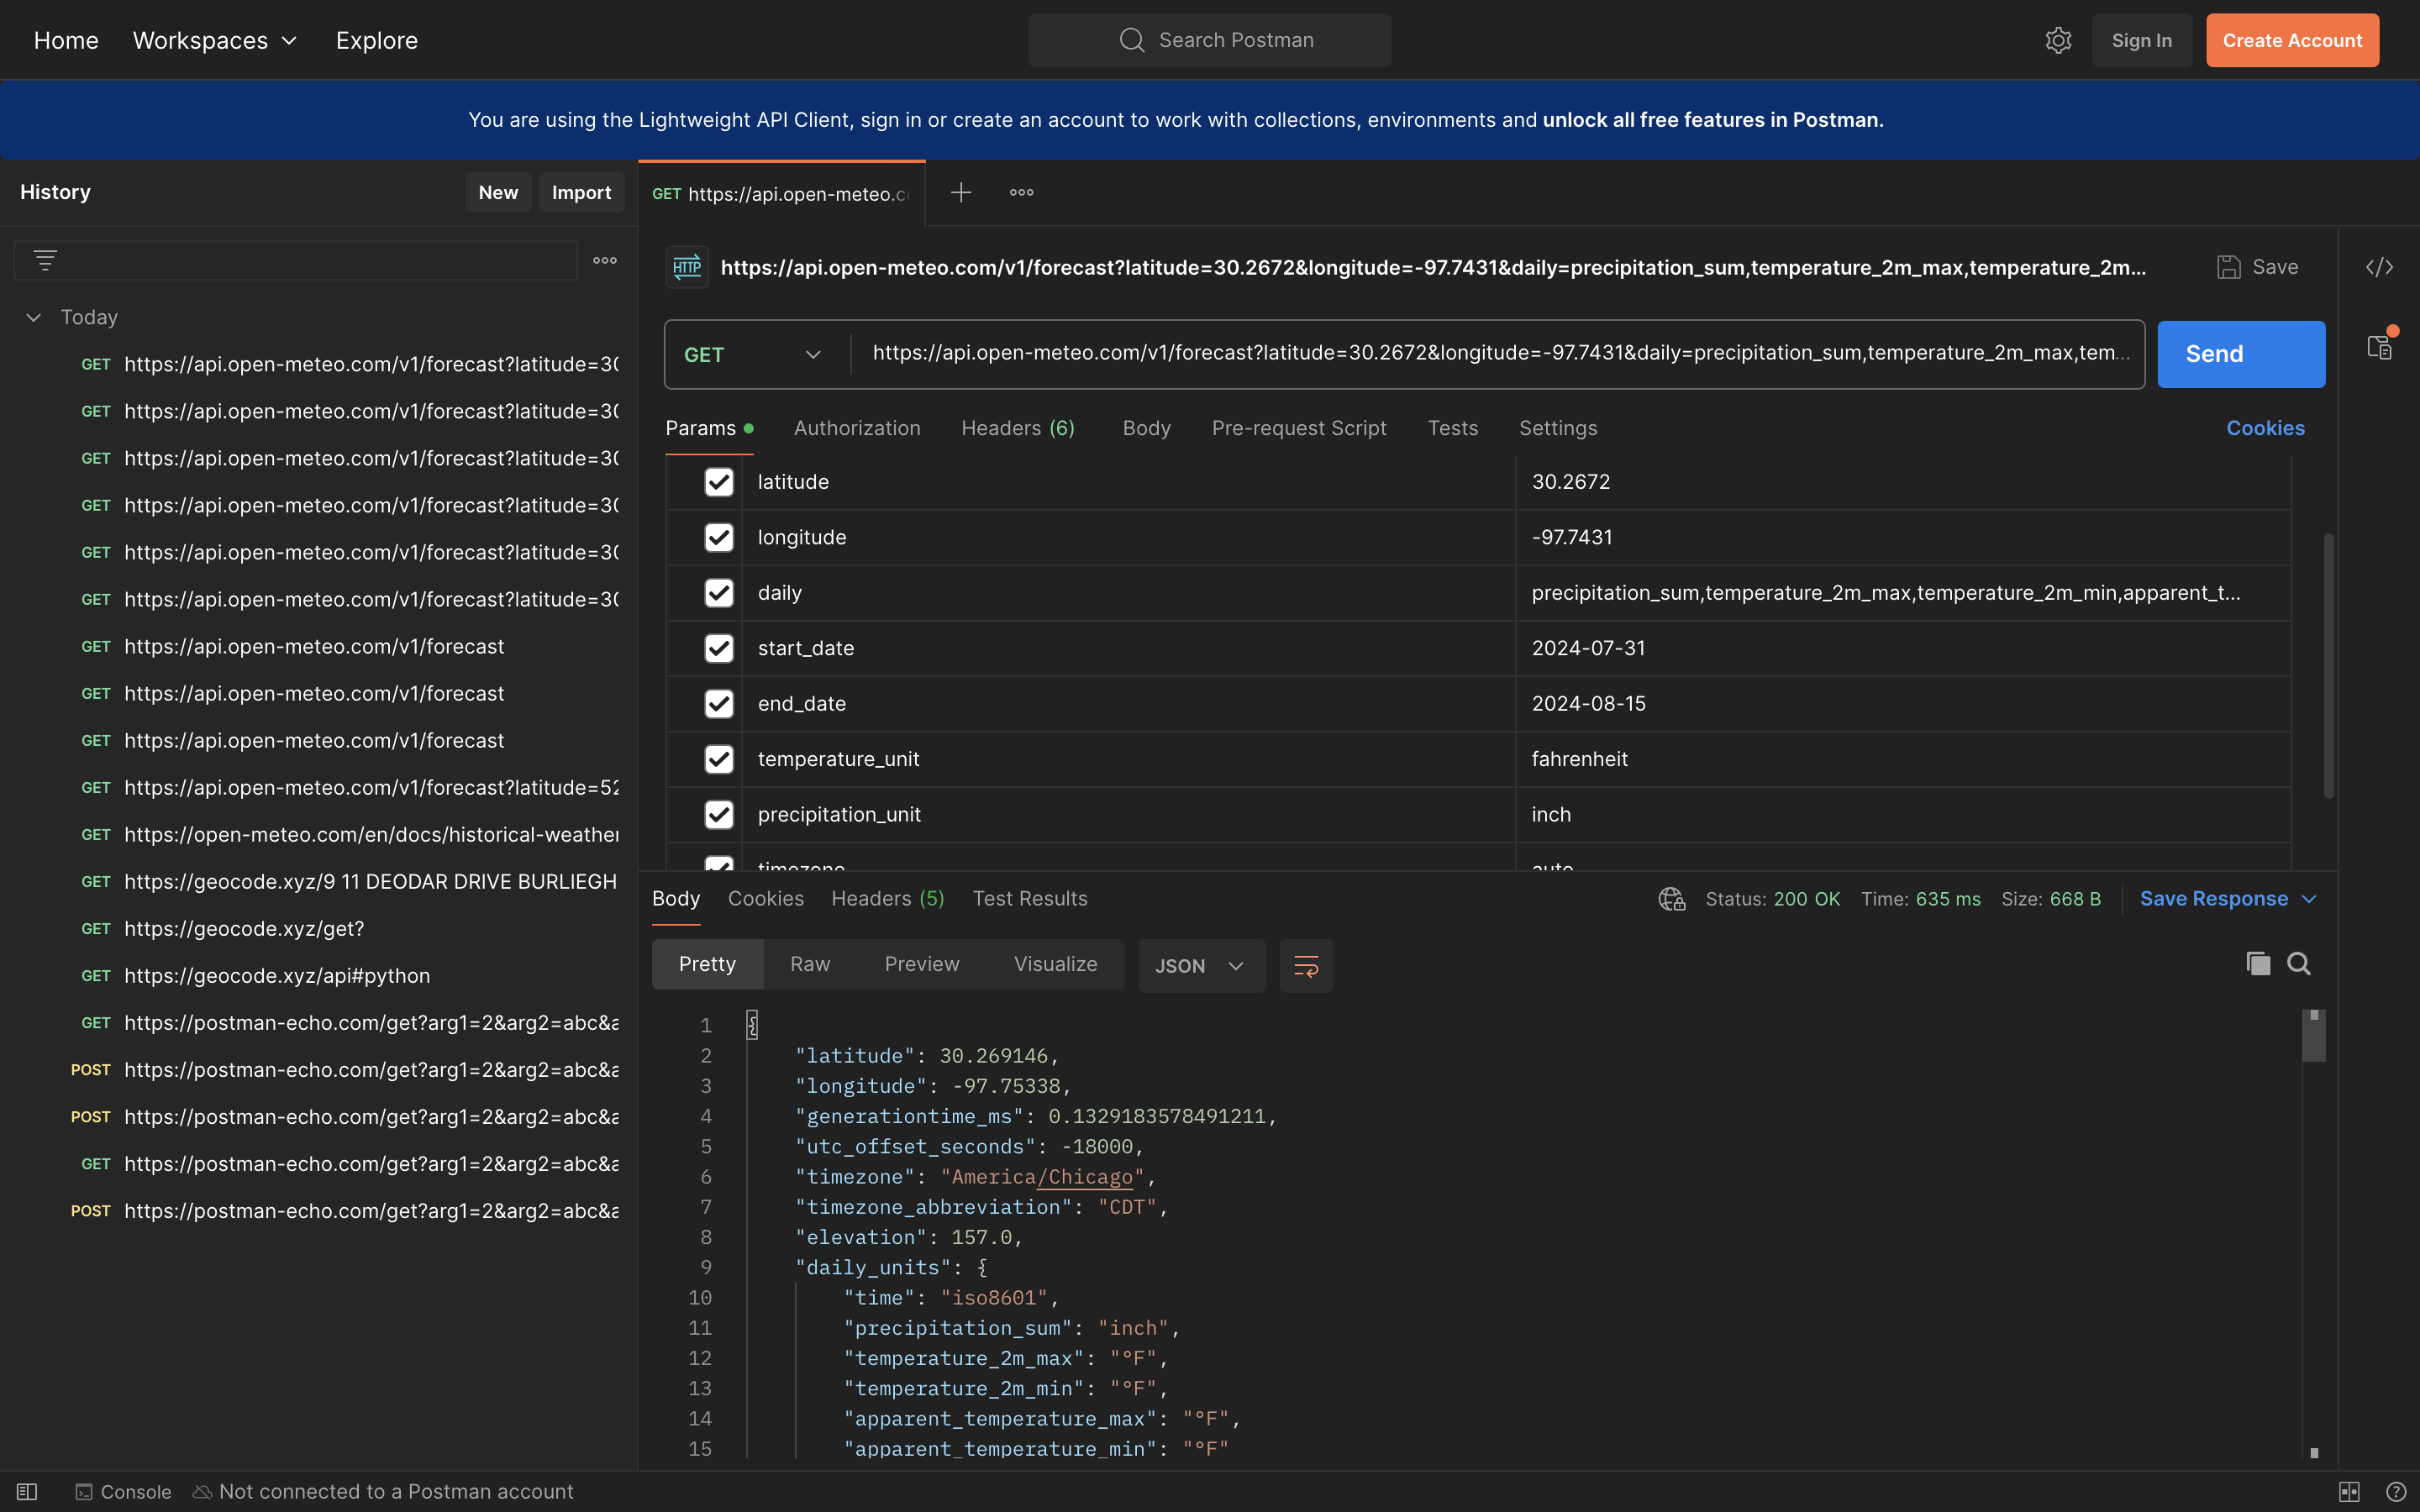

In [3]:
# helper function for 15-day date range
def get_date_range(birthday: date):
    start_date = birthday - timedelta(days=7)
    end_date = birthday + timedelta(days=7)
    return {
        'start_date': start_date.strftime('%Y-%m-%d'),
        'end_date': end_date.strftime('%Y-%m-%d')
    }
    
birthday = date.fromisoformat('2020-08-05')
date_range = get_date_range(birthday)
print(date_range)

{'start_date': '2020-07-29', 'end_date': '2020-08-12'}


In [4]:
# write your solution here
def get_api_response(latitude, longitude, start_date, end_date):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    response = requests.get(base_url, params={
        'latitude': latitude,
        'longitude': longitude,
        'start_date': start_date,
        'end_date': end_date,
        'daily': 'precipitation_sum,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min',
        'temperature_unit': 'fahrenheit',
        'precipitation_unit': 'inch',
        'timezone': 'auto'
    })
    return response.json()

### Iterating Over Each Year
Write a function that iterates through each year between 1960 and 2022 and returns the corresponding JSON response objects containing weather data for each year in a python list.

```
def get_all_response_objects(start_year, end_year):
    # your code
```


In [22]:
import tqdm

def get_all_response_objects(latitude, longitude, birthday):
    response_objects = []
    for year in tqdm.tqdm(range(1960, 2023), desc='Fetching Data'):
        current_date = date(year, birthday.month, birthday.day)
        date_range = get_date_range(current_date)
        res = get_api_response(latitude, longitude, date_range['start_date'], date_range['end_date'])
        response_objects.append(res)
    return response_objects

### Parse JSON Responses & Aggregate Data
Write a function that takes the list of JSON response objects from the previous function in as a parameter and returns a pandas DataFrame containing the original input date, the measurements, and the average across the 15 days.
```
def parse_json_response(responses):
    # your code
```


In [7]:
def parse_json_response(responses):
    df = pd.DataFrame()
    for response in responses:
        daily_data = response.get('daily', {})
        if daily_data:
            df = pd.concat([df, pd.DataFrame(daily_data)], axis='rows')
    return df

### Combining the Functions
Write a function that combines all the above functions into one, where the user inputs their birthday and location and the function returns the pandas DataFrame containing the summary of measurements.

```
def get_data():
    birthday = get_user_birthday()
    location = get_user_city_of_birth()
    # your code here
```

The helper functions below can be used for birthday and location input information:

In [10]:
def get_data():
    # Helper functions for user input
    def get_user_birthday():
        birthday = input('Enter your birthday (MM/DD/YYYY): ')
        return datetime.strptime(birthday, "%m/%d/%Y")
    
    def get_user_city_of_birth():
        city = input('Enter your city of birth: ')
        country = input('Enter your country of birth: ')
        return city, country

    # user input
    birthday = get_user_birthday()
    city, country = get_user_city_of_birth()
    
    # latitude and longitude
    latitude, longitude = geocode_location(city, country)
    
    # weather data
    responses = get_all_response_objects(latitude, longitude, birthday)
    
    # parse and return data
    df = parse_json_response(responses)
    return df

Run your function and set it equal to `df`:

In [13]:
df = get_data()
print(df.head(10))

Enter your birthday (MM/DD/YYYY):  09/09/2000
Enter your city of birth:  Austin
Enter your country of birth:  US


Fetching Data: 100%|████████████████████████████| 63/63 [00:43<00:00,  1.46it/s]

         time  precipitation_sum  temperature_2m_max  temperature_2m_min  \
0  1960-09-02              0.114                92.3                74.2   
1  1960-09-03              0.102                91.9                72.4   
2  1960-09-04              0.020                89.8                73.9   
3  1960-09-05              0.000                91.2                72.2   
4  1960-09-06              0.000                91.8                73.2   
5  1960-09-07              0.020                88.8                69.4   
6  1960-09-08              0.016                91.0                73.1   
7  1960-09-09              0.012                94.1                73.4   
8  1960-09-10              0.004                86.5                76.0   
9  1960-09-11              0.000                87.5                70.6   

   apparent_temperature_max  apparent_temperature_min  
0                      97.8                      82.5  
1                      98.3                      80

## Question 3: Visualizing The Data
Plot the DataFrame using `matplotlib`/`seaborn` and write a short summary of your results.

Text(0, 0.5, 'Precipitation (inches)')

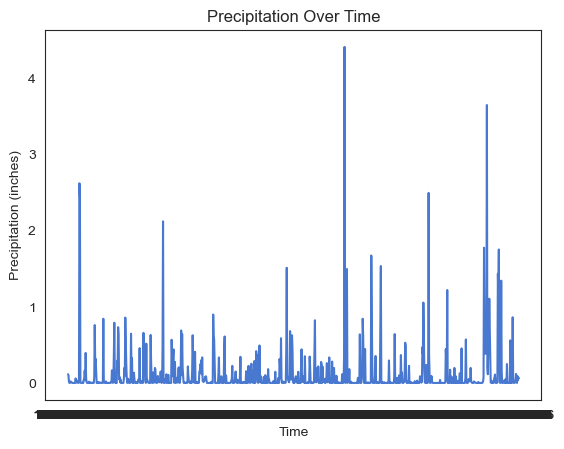

In [29]:
# enter your code here
sns.lineplot(data=df, x='time', y='precipitation_sum')
plt.title('Precipitation Over Time')
plt.xlabel('Time')
plt.ylabel('Precipitation (inches)')

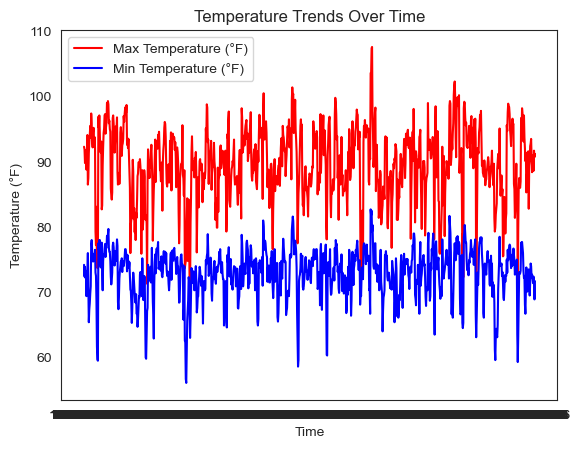

In [28]:
sns.lineplot(data=df, x='time', y='temperature_2m_max', label='Max Temperature (°F)', color='red')
sns.lineplot(data=df, x='time', y='temperature_2m_min', label='Min Temperature (°F)', color='blue')
plt.title('Temperature Trends Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°F)')
plt.legend()

### Results Summary:

The precipitation plot shows notable fluctuations, with several days experiencing significant rainfall. The peaks likely represent days with intense weather conditions. Aside from these peaks, the rainfall levels appear to be relatively modest, indicating that extreme weather was not a constant factor.

The temperature trends exhibit expected seasonal patterns around the chosen date. The maximum temperatures generally range between 75°F and 100°F, while minimum temperatures stay between 60°F and 80°F. There are occasional deviations from these ranges, but the temperatures remain consistent with seasonal expectations and never fall to extremes.

The visualizations effectively capture the typical weather variations, showcasing the expected temperature and precipitation patterns around the selected date. They highlight both the normal seasonal fluctuations and instances of significant weather events.